In [1]:
import asyncio
import itertools
import logging
import random
import nest_asyncio
import pandas as pd

nest_asyncio.apply()  #

In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union

from nuplan.planning.script.run_simulation import main as main_simulation

KeyboardInterrupt: 

In [ ]:
%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [ ]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import (
    run_runners,
    set_default_path,
    set_up_common_builder,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv("NUPLAN_HYDRA_CONFIG_PATH", "config/simulation")

if os.environ.get("NUPLAN_HYDRA_CONFIG_PATH") is not None:
    CONFIG_PATH = os.path.join("../../../../", CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != "simulation":
    CONFIG_PATH = os.path.join(CONFIG_PATH, "simulation")
CONFIG_NAME = "default_simulation"

In [ ]:
# list of selected scenario tokens
from tokens import selected_scenario_tokens, modifiable_scenario_tokens

print(selected_scenario_tokens[0:3])
print(modifiable_scenario_tokens[0:3])

selected_scenario_tokens = ["0c308ff01686526d"]

['d6234553edc95d50', '98ddd7851e445b7a', '5ac5795b9b5851e8']
['014c7f3502d4597d', '02828821ef045829', '02fa9b8d43465e0d']


In [ ]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(
    os.getenv("NUPLAN_TUTORIAL_PATH", ""), "../nuplan/planning/script"
)
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

In [ ]:
left_turn_types = [
    "stopping_at_crosswalk",
    "high_lateral_acceleration",
    "near_multiple_vehicles",
    "on_stopline_stop_sign",
    "near_long_vehicle",
    "unknown",
    "near_barrier_on_driveable",
    "near_high_speed_vehicle",
]
scenario_types = [
    "starting_left_turn",
    # "accelerating_at_traffic_light_with_lead",
    # "crossed_by_bike",
    # "crossed_by_vehicle",
    # "on_intersection",
    # "on_stopline_crosswalk",
    # "on_stopline_stop_sign",
    # "on_stopline_traffic_light",
    # "on_traffic_light_intersection",
    # "starting_protected_cross_turn",
    # "starting_protected_noncross_turn",
    "starting_right_turn",
    "starting_straight_stop_sign_intersection_traversal",
    "starting_straight_traffic_light_intersection_traversal",
    # "starting_u_turn",
    "starting_unprotected_cross_turn",
    "starting_unprotected_noncross_turn",
    # "stationary_at_crosswalk",
    # "stationary_at_traffic_light_with_lead",
    # "stationary_at_traffic_light_without_lead",
    # "traversing_crosswalk",
    "traversing_intersection",
    "traversing_traffic_light_intersection",
]

left_turn_potential = [
    "starting_left_turn",
    "starting_unprotected_cross_turn",
]

# scenario_types = ['stationary_at_traffic_light_without_lead']

scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
DATASET_PARAMS = [
    f"scenario_builder={scenario_builder}",
    "scenario_filter=all_scenarios",  # [all_scenarios, val14_split]
    f"scenario_filter.scenario_types={scenario_types}",  # there are 70 scenario types in the trainingset and 58 in the validation set including "unknown" which make up the majority
    "scenario_filter.ego_displacement_minimum_m=10",  # use scenarios where the ego vehicle moves at least 10m
    #    'scenario_filter.remove_invalid_goals=true',  # remove scenarios where the goal is not invalid
    # "scenario_filter.ego_start_speed_threshold=5",  # Exclusive threshold that the ego's speed must rise above (meters per second) for scenario to be kept
    #    'scenario_filter.stop_speed_threshold=10',  # Inclusive threshold that the ego's speed must fall below (meters per second) for scenario to be kept:
    "scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]",  # select multiple [sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]
    # "scenario_filter.limit_total_scenarios=0.05",  # use n total scenarios if int, or if float smaller than 1, use n as a fraction of total scenarios (changes sampling frequency, unchanged leaves the frequency at 20Hz)
    "scenario_filter.num_scenarios_per_type=10",  # use 10 scenarios per scenario type
    # f"scenario_filter.scenario_tokens={selected_scenario_tokens}",  # List of scenarios to include (token)
    #'scenario_filter.log_names=["2021.08.24.20.03.01_veh-45_01091_01622"]',  # specific scenrios to simulate
    # turn off if you are selecting scenarios manually. turn on for initial filtering (0.05 gives us 1 scenario per second)
]

In [ ]:
urban_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt"
gc_pgp_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/gc_pgp_checkpoint.ckpt"
hybrid_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt"
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg_occ = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        # "model=gc_pgp_model",
        # "model.aggregator.pre_train=false",
        # "planner.ml_planner.model_config=${model}",
        # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
        # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
        # "+observation.model=gc_pgp_model",
        # "+observation.model.aggregator.pre_train=false",
        # "+observation.model_config=${model}",
        # f"+observation.checkpoint_path={gc_pgp_ckpt}",
        f"observation.planner_type=pdm_closed",
        # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
        f"observation.occlusion_cfg.occlusion=True",
        f"observation.occlusion_cfg.manager_type=wedge",
        f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
        f"+observation.occlusion_cfg.notice_threshold=1.0",
        "+modify_scenario_simulations=true",
        "+modifier_types=[conflict-and-occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right, oncoming-left-turn-and-occlusion-injection, conflict-and-occlusion-injection]
        "+occlusion=True",
        "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
        "+occlusion.uncloak_reaction_time=1.5",  # 0.1
        "+occlusion.notice_threshold=1.0",  # 0.1
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
    ],
)

output_folder_occ = cfg_occ.output_dir
print('output_folder_occ = "' + output_folder_occ + '"')


# closed mixed for simulation
# "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
# "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
# # "model=gc_pgp_model",
# # "model.aggregator.pre_train=false",
# # "planner.ml_planner.model_config=${model}",
# # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
# # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
# # "+observation.model=gc_pgp_model",
# # "+observation.model.aggregator.pre_train=false",
# # "+observation.model_config=${model}",
# # f"+observation.checkpoint_path={gc_pgp_ckpt}",
# f"observation.planner_type=pdm_closed",
# # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
# f"observation.occlusion_cfg.occlusion=true",
# f"observation.occlusion_cfg.manager_type=wedge",
# f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
# f"+observation.occlusion_cfg.notice_threshold=1.0",
# "+modify_scenario_simulations=true",
# "+modifier_types=[occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right]
# "+occlusion=true",
# "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
# "+occlusion.uncloak_reaction_time=1.0",
# "+occlusion.notice_threshold=0.1",
# "worker=ray_distributed",  # [sequential, ray_distributed]
# "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
# *DATASET_PARAMS,

# openloop config for finding risky scenarios
# f"scenario_builder={scenario_builder}",
# "scenario_filter=all_scenarios",  # [all_scenarios, val14_split]
# # f"scenario_filter.scenario_types={left_turn_types}",  # there are 70 scenario types in the trainingset and 58 in the validation set including "unknown" which make up the majority
# "scenario_filter.ego_displacement_minimum_m=10",  # use scenarios where the ego vehicle moves at least 10m
# #    'scenario_filter.remove_invalid_goals=true',  # remove scenarios where the goal is not invalid
# "scenario_filter.ego_start_speed_threshold=5",  # Exclusive threshold that the ego's speed must rise above (meters per second) for scenario to be kept
# #    'scenario_filter.stop_speed_threshold=10',  # Inclusive threshold that the ego's speed must fall below (meters per second) for scenario to be kept:
# "scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood]",  # select multiple [sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]
# # "scenario_filter.num_scenarios_per_type=300",  # use 10 scenarios per scenario type
# # f"scenario_filter.scenario_tokens={selected_scenario_tokens}",  # List of scenarios to include (token)
# #'scenario_filter.log_names=["2021.08.24.20.03.01_veh-45_01091_01622"]',  # specific scenrios to simulate
# "scenario_filter.limit_total_scenarios=0.01",  # use n total scenarios if int, or if float smaller than 1, use n as a fraction of total scenarios (changes sampling frequency, unchanged leaves the frequency at 20Hz)
# # turn off if you are selecting scenarios manually. turn on for initial filtering (0.05 gives us 1 scenario per second)


# "+simulation=open_loop_boxes",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
#         "planner=log_future_planner",  # [ml_planner, pdm_hybrid_planner, gc_pgp_planner, idm_planner, log_future_planner, simple_planner]
#         "ego_controller=perfect_tracking_controller",
#         "worker=ray_distributed",  # [sequential, ray_distributed]
#         "+occlusion=true",  # [true, false]
#         "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
#         "+occlusion.uncloak_reaction_time=1.5",
#         "+occlusion.notice_threshold=1.0",
#         # "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
#         *DATASET_PARAMS,


# output folders for runs:
# closed_loop_reactive_agents, wedge occlusions, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
# overall score: 0.5041, ego_at_fault_collisions: 363

# closed_loop_reactive_agents, occlusions = False, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13"
# overall score: 0.5041, ego_at_fault_collisions: 357

# closed_loop_nonreactive_agents, occlusions = False, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.02.01.14"
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41"
# overall score: , ego_at_fault_collisions:

# closed_loop_nonreactive_agents, wedge occlusions, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23"
# overall score: , ego_at_fault_collisions:

# closed_loop_reactive_agents, wedge occlusions, gc_pgp
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44"
# overall score: , ego_at_fault_collisions:

# 'closed_loop_reactive_agents, occlusions = False, gc_pgp'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30"

# 'closed_loop_reactive_agents, occlusions = False, pdm_hybrid'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28"

# 'closed_loop_reactive_agents,  wedge occlusions, pdm_hybrid'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48"

# # be8c7a230b9c5b4e_oncoming_vehicle_injection_for_left_turn_and_occlusion_injection_0
# # output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.14.14.14.30"
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.14.14.38.02"

default_simulation
output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.03.04.22.23.53"


# Now we can run with the following

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2024-03-04 22:23:54,237 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-03-04 22:23:54,238 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-03-04 22:23:56,062	INFO worker.py:1636 -- Started a local Ray instance.


2024-03-04 22:23:56,762 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-03-04 22:23:56,762 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-03-04 22:23:56,762 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-03-04 22:23:56,762 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-03-04 22:23:56,762 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.03.04.22.23.53

2024-03-04 22:23:56,764 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]
(raylet) [2024-03-04 22:24:05,957 E 10326 10341] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_22-23-54_272709_9518 is over 95% full, available space: 657704218624; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-03-04 22:24:09,785 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:83}  Building metric engines...
2024-03-04 22:24:10,120 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:85}  Building metric engines...DONE
2024-03-04 22:24:10,121 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:89}  Building simulations from 152 scenarios...
2024-03-04 22:24:12,356 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:151}  Modyfing Scenarios...
1 0 are the number of cpus and gpus
2024-03-04 22:24:12,357 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:116}  Submitting 152 tasks!
(wrapped_fn pid=10425) Left turn 18564 in scenario 11d427e2ed295324 has a red traffic light
(wrapped_fn pid=10427) Warning: ego in scenario 0bd3ee0c8e1357b2 has no conflict lanes intersecting its path


(raylet) [2024-03-04 22:24:15,961 E 10326 10341] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_22-23-54_272709_9518 is over 95% full, available space: 657704206336; capacity: 16125711347712. Object creation will fail if spilling is required.


(wrapped_fn pid=10421) Warning: Ego does not cross an intersection in scenario with token: 1279363f8672528a.
(wrapped_fn pid=10421) Left turn 18405 in scenario 4a09d29d43815d7b has a red traffic light [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(wrapped_fn pid=10433) Warning: ego in scenario 22cda6ef461e5666 has no conflict lanes intersecting its path [repeated 9x across cluster]


(raylet) [2024-03-04 22:24:25,969 E 10326 10341] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_22-23-54_272709_9518 is over 95% full, available space: 657702227968; capacity: 16125711347712. Object creation will fail if spilling is required.


(wrapped_fn pid=10430) Left turn 70518 in scenario 6ea37f738f3f5907 has a red traffic light
(wrapped_fn pid=10436) Warning: ego in scenario 6a0f3cb4ea235579 has no conflict lanes intersecting its path [repeated 8x across cluster]
(wrapped_fn pid=10439) Left turn 70486 in scenario 6a2df5d7a7bf5c63 has a red traffic light
(wrapped_fn pid=10431) Warning: ego in scenario 91ecf9ddc57f5a11 has no conflict lanes intersecting its path [repeated 9x across cluster]
(wrapped_fn pid=10431) Warning: ego in scenario 8a11616e904152be has no conflict lanes intersecting its path


(raylet) [2024-03-04 22:24:35,977 E 10326 10341] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_22-23-54_272709_9518 is over 95% full, available space: 657704198144; capacity: 16125711347712. Object creation will fail if spilling is required.


(wrapped_fn pid=10435) Left turn 70518 in scenario aaa28af94ac15ae4 has a red traffic light
(wrapped_fn pid=10435) Warning: ego in scenario af7356c6e1d551be has no conflict lanes intersecting its path [repeated 4x across cluster]


Ray objects:  53%|█████▎    | 81/152 [00:00<00:00, 158.84it/s]

(wrapped_fn pid=10432) Left turn 18452 in scenario b683e3722ee8570d has a red traffic light [repeated 2x across cluster]
(wrapped_fn pid=10447) Warning: ego in scenario c60cd30825795e00 has no conflict lanes intersecting its path [repeated 5x across cluster]


Ray objects:  71%|███████   | 108/152 [00:07<00:04,  9.60it/s]

(wrapped_fn pid=10423) Left turn 18590 in scenario e6bb1d7221af5462 has a red traffic light [repeated 3x across cluster]


Ray objects:  76%|███████▌  | 115/152 [00:12<00:08,  4.31it/s]

(wrapped_fn pid=10434) Warning: ego in scenario eaeb329bac135fb3 has no conflict lanes intersecting its path [repeated 4x across cluster]


Ray objects:  79%|███████▉  | 120/152 [00:14<00:08,  3.80it/s]

(wrapped_fn pid=10433) Warning: ego in scenario f551e95b15b95bfe has no conflict lanes intersecting its path


Ray objects:  80%|████████  | 122/152 [00:14<00:07,  3.97it/s]

(wrapped_fn pid=10429) Left turn 70507 in scenario f82cc0bc23df5ee9 has a red traffic light


Ray objects:  99%|█████████▊| 150/152 [00:50<00:05,  2.82s/it](raylet) [2024-03-04 22:25:36,016 E 10326 10341] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_22-23-54_272709_9518 is over 95% full, available space: 657704026112; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 22:25:46,019 E 10326 10341] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_22-23-54_272709_9518 is over 95% full, available space: 657704022016; capacity: 16125711347712. Object creation will fail if spilling is required.
Ray objects:  99%|█████████▉| 151/152 [01:14<00:08,  8.99s/it](raylet) [2024-03-04 22:25:56,021 E 10326 10341] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_22-23-54_272709_9518 is over 95% full, available space: 657703989248; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 22:26:06,023 E 10326 10341] (raylet) file_system_monitor.cc:111: /tmp/ra

2024-03-04 22:26:41,089 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 8 modified scenarios from scenario with token: 014ef3bc5af25944.


100%|██████████| 8/8 [00:00<00:00, 835.37it/s]
0it [00:00, ?it/s]

2024-03-04 22:26:41,101 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 5 modified scenarios from scenario with token: 0489f98ba4695a8f.


100%|██████████| 5/5 [00:00<00:00, 815.12it/s]
0it [00:00, ?it/s]

2024-03-04 22:26:41,110 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 7 modified scenarios from scenario with token: 09e3ad03693c59da.


100%|██████████| 7/7 [00:00<00:00, 795.82it/s]
0it [00:00, ?it/s]

2024-03-04 22:26:41,121 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 9 modified scenarios from scenario with token: 0c308ff01686526d.


100%|██████████| 9/9 [00:00<00:00, 854.06it/s]
0it [00:00, ?it/s]

2024-03-04 22:26:41,134 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 1 modified scenarios from scenario with token: 101e1ed22ce155be.


100%|██████████| 1/1 [00:00<00:00, 736.36it/s]
0it [00:00, ?it/s]

2024-03-04 22:26:41,138 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 3 modified scenarios from scenario with token: 1733f3612f995a04.


100%|██████████| 3/3 [00:00<00:00, 822.14it/s]
0it [00:00, ?it/s]

2024-03-04 22:26:41,144 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 1 modified scenarios from scenario with token: 19704ac6c0535714.


100%|██████████| 1/1 [00:00<00:00, 701.86it/s]
0it [00:00, ?it/s]

2024-03-04 22:26:41,147 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 1 modified scenarios from scenario with token: 1a0804f69e90522e.


100%|██████████| 1/1 [00:00<00:00, 764.55it/s]
0it [00:00, ?it/s]

2024-03-04 22:26:41,151 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 3 modified scenarios from scenario with token: 1af5393b4c22528a.


100%|██████████| 3/3 [00:00<00:00, 820.27it/s]
0it [00:00, ?it/s]

2024-03-04 22:26:41,157 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 1 modified scenarios from scenario with token: 1cb8625b8f995cf8.


100%|██████████| 1/1 [00:00<00:00, 714.05it/s]
0it [00:00, ?it/s]

2024-03-04 22:26:41,160 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 7 modified scenarios from scenario with token: 211737e41e9f50c9.


100%|██████████| 7/7 [00:00<00:00, 833.74it/s]
0it [00:00, ?it/s]

2024-03-04 22:26:41,171 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 12 modified scenarios from scenario with token: 243ea67f27195c7c.


100%|██████████| 12/12 [00:00<00:00, 841.58it/s]
0it [00:00, ?it/s]

2024-03-04 22:26:41,187 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 9 modified scenarios from scenario with token: 2b430abcf49554c7.


100%|██████████| 9/9 [00:00<00:00, 833.67it/s]
31it [00:00, 279.06it/s]

2024-03-04 22:26:41,201 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 7 modified scenarios from scenario with token: 30a56d9819f5500a.


100%|██████████| 7/7 [00:00<00:00, 842.57it/s]
31it [00:00, 279.06it/s]

2024-03-04 22:26:41,211 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 1 modified scenarios from scenario with token: 33033416cd21523d.


100%|██████████| 1/1 [00:00<00:00, 687.25it/s]
31it [00:00, 279.06it/s]

2024-03-04 22:26:41,215 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 21 modified scenarios from scenario with token: 35936614e99c5e38.


100%|██████████| 21/21 [00:00<00:00, 853.83it/s]
31it [00:00, 279.06it/s]

2024-03-04 22:26:41,244 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 11 modified scenarios from scenario with token: 3ad61242db035638.


100%|██████████| 11/11 [00:00<00:00, 840.74it/s]
31it [00:00, 279.06it/s]

2024-03-04 22:26:41,259 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 6 modified scenarios from scenario with token: 3ebdf29d55045ed0.


100%|██████████| 6/6 [00:00<00:00, 826.82it/s]
31it [00:00, 279.06it/s]

2024-03-04 22:26:41,268 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 6 modified scenarios from scenario with token: 4197fbbd54a95c24.


100%|██████████| 6/6 [00:00<00:00, 802.48it/s]
31it [00:00, 279.06it/s]

2024-03-04 22:26:41,278 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 15 modified scenarios from scenario with token: 47b74fe4791a52c0.


100%|██████████| 15/15 [00:00<00:00, 832.23it/s]
31it [00:00, 279.06it/s]

2024-03-04 22:26:41,299 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 8 modified scenarios from scenario with token: 47b945adf5ff5f7d.


100%|██████████| 8/8 [00:00<00:00, 840.18it/s]
31it [00:00, 279.06it/s]

2024-03-04 22:26:41,311 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 4 modified scenarios from scenario with token: 4c98ab1dc1cd5200.


100%|██████████| 4/4 [00:00<00:00, 856.46it/s]
31it [00:00, 279.06it/s]

2024-03-04 22:26:41,318 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 8 modified scenarios from scenario with token: 4e5f13bdc96e552f.


100%|██████████| 8/8 [00:00<00:00, 824.90it/s]
31it [00:00, 279.06it/s]

2024-03-04 22:26:41,330 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 4 modified scenarios from scenario with token: 52c24c5eef865775.


100%|██████████| 4/4 [00:00<00:00, 739.96it/s]
31it [00:00, 279.06it/s]

2024-03-04 22:26:41,338 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 3 modified scenarios from scenario with token: 59ef9500cad45425.


100%|██████████| 3/3 [00:00<00:00, 810.18it/s]
31it [00:00, 279.06it/s]

2024-03-04 22:26:41,344 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 4 modified scenarios from scenario with token: 5bdce36221ec5c7d.


100%|██████████| 4/4 [00:00<00:00, 826.71it/s]
59it [00:00, 217.78it/s]

2024-03-04 22:26:41,351 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 4 modified scenarios from scenario with token: 5bf602b113005389.


100%|██████████| 4/4 [00:00<00:00, 843.03it/s]
59it [00:00, 217.78it/s]

2024-03-04 22:26:41,358 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 7 modified scenarios from scenario with token: 6895e06f4b645c9b.


100%|██████████| 7/7 [00:00<00:00, 845.24it/s]
59it [00:00, 217.78it/s]

2024-03-04 22:26:41,369 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 2 modified scenarios from scenario with token: 764f667f1ffa5b26.


100%|██████████| 2/2 [00:00<00:00, 814.19it/s]
59it [00:00, 217.78it/s]

2024-03-04 22:26:41,374 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 2 modified scenarios from scenario with token: 76c678d147155f9b.


100%|██████████| 2/2 [00:00<00:00, 757.44it/s]
59it [00:00, 217.78it/s]

2024-03-04 22:26:41,379 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 3 modified scenarios from scenario with token: 77d72d48232d59a7.


100%|██████████| 3/3 [00:00<00:00, 839.70it/s]
59it [00:00, 217.78it/s]

2024-03-04 22:26:41,385 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 2 modified scenarios from scenario with token: 7c518fcf126251e5.


100%|██████████| 2/2 [00:00<00:00, 780.34it/s]
59it [00:00, 217.78it/s]

2024-03-04 22:26:41,390 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 4 modified scenarios from scenario with token: 819daa5c38e853ec.


100%|██████████| 4/4 [00:00<00:00, 846.61it/s]
59it [00:00, 217.78it/s]

2024-03-04 22:26:41,397 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 13 modified scenarios from scenario with token: 89ddadce7c875ca2.


100%|██████████| 13/13 [00:00<00:00, 839.66it/s]
59it [00:00, 217.78it/s]

2024-03-04 22:26:41,414 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 27 modified scenarios from scenario with token: 8b80aa05d88b518b.


100%|██████████| 27/27 [00:00<00:00, 867.59it/s]
59it [00:00, 217.78it/s]

2024-03-04 22:26:41,448 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 3 modified scenarios from scenario with token: 9e306573ac3c53dc.


100%|██████████| 3/3 [00:00<00:00, 847.73it/s]
94it [00:00, 265.95it/s]

2024-03-04 22:26:41,454 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 23 modified scenarios from scenario with token: a1c624f373555774.


100%|██████████| 23/23 [00:00<00:00, 850.14it/s]
94it [00:00, 265.95it/s]

2024-03-04 22:26:41,483 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 3 modified scenarios from scenario with token: a41ed0bc8aff506b.


100%|██████████| 3/3 [00:00<00:00, 789.00it/s]
94it [00:00, 265.95it/s]

2024-03-04 22:26:41,489 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 4 modified scenarios from scenario with token: a565ba85bf745c73.


100%|██████████| 4/4 [00:00<00:00, 827.69it/s]
94it [00:00, 265.95it/s]

2024-03-04 22:26:41,496 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 3 modified scenarios from scenario with token: a6a80c6e2c195c6b.


100%|██████████| 3/3 [00:00<00:00, 713.07it/s]
94it [00:00, 265.95it/s]

2024-03-04 22:26:41,503 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 9 modified scenarios from scenario with token: a7f1731ff7c35faa.


100%|██████████| 9/9 [00:00<00:00, 829.88it/s]
94it [00:00, 265.95it/s]

2024-03-04 22:26:41,516 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 9 modified scenarios from scenario with token: a91bbdd53829507d.


100%|██████████| 9/9 [00:00<00:00, 818.76it/s]
94it [00:00, 265.95it/s]

2024-03-04 22:26:41,530 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 2 modified scenarios from scenario with token: b293b6dde835561f.


100%|██████████| 2/2 [00:00<00:00, 743.14it/s]
94it [00:00, 265.95it/s]

2024-03-04 22:26:41,535 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 16 modified scenarios from scenario with token: baae90210b9f5121.


100%|██████████| 16/16 [00:00<00:00, 850.04it/s]
94it [00:00, 265.95it/s]

2024-03-04 22:26:41,556 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 5 modified scenarios from scenario with token: bcc8a718ee29542c.


100%|██████████| 5/5 [00:00<00:00, 833.26it/s]
94it [00:00, 265.95it/s]

2024-03-04 22:26:41,565 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 27 modified scenarios from scenario with token: bd72e5b0d1265eec.


100%|██████████| 27/27 [00:00<00:00, 839.66it/s]
122it [00:00, 233.33it/s]

2024-03-04 22:26:41,599 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 17 modified scenarios from scenario with token: ccf23a9288075b08.


100%|██████████| 17/17 [00:00<00:00, 677.24it/s]
122it [00:00, 233.33it/s]

2024-03-04 22:26:41,627 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 13 modified scenarios from scenario with token: ce292147220555b8.


100%|██████████| 13/13 [00:00<00:00, 825.01it/s]
122it [00:00, 233.33it/s]

2024-03-04 22:26:41,645 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 8 modified scenarios from scenario with token: d5588e98c9a454da.


100%|██████████| 8/8 [00:00<00:00, 833.28it/s]
122it [00:00, 233.33it/s]

2024-03-04 22:26:41,658 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 6 modified scenarios from scenario with token: d6cb5239199b531c.


100%|██████████| 6/6 [00:00<00:00, 781.23it/s]
122it [00:00, 233.33it/s]

2024-03-04 22:26:41,668 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 1 modified scenarios from scenario with token: d6e87233d7635cfb.


100%|██████████| 1/1 [00:00<00:00, 708.62it/s]
122it [00:00, 233.33it/s]

2024-03-04 22:26:41,672 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 19 modified scenarios from scenario with token: d85a70f566115754.


100%|██████████| 19/19 [00:00<00:00, 833.06it/s]
122it [00:00, 233.33it/s]

2024-03-04 22:26:41,698 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 14 modified scenarios from scenario with token: d8878c93341a583d.


100%|██████████| 14/14 [00:00<00:00, 811.40it/s]
122it [00:00, 233.33it/s]

2024-03-04 22:26:41,717 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 4 modified scenarios from scenario with token: e95f7abcea4854d4.


100%|██████████| 4/4 [00:00<00:00, 845.24it/s]
122it [00:00, 233.33it/s]

2024-03-04 22:26:41,724 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 7 modified scenarios from scenario with token: eb857c67766b53ce.


100%|██████████| 7/7 [00:00<00:00, 859.54it/s]
122it [00:00, 233.33it/s]

2024-03-04 22:26:41,735 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 7 modified scenarios from scenario with token: efd71b7af2f45f96.


100%|██████████| 7/7 [00:00<00:00, 847.07it/s]
147it [00:00, 209.39it/s]

2024-03-04 22:26:41,745 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 7 modified scenarios from scenario with token: f9fb1ccf7b0a5936.


100%|██████████| 7/7 [00:00<00:00, 863.46it/s]
147it [00:00, 209.39it/s]

2024-03-04 22:26:41,756 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 3 modified scenarios from scenario with token: fc7fd7ff2f2c5d5d.


100%|██████████| 3/3 [00:00<00:00, 800.69it/s]
147it [00:00, 209.39it/s]

2024-03-04 22:26:41,762 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:184}  Created 1 modified scenarios from scenario with token: fef8d90af3345bbe.


100%|██████████| 1/1 [00:00<00:00, 756.68it/s]
152it [00:00, 224.73it/s]


[
	'014ef3bc5af25944',
	'0489f98ba4695a8f',
	'09e3ad03693c59da',
	'0c308ff01686526d',
	'101e1ed22ce155be',
	'1733f3612f995a04',
	'19704ac6c0535714',
	'1a0804f69e90522e',
	'1af5393b4c22528a',
	'1cb8625b8f995cf8',
	'211737e41e9f50c9',
	'243ea67f27195c7c',
	'2b430abcf49554c7',
	'30a56d9819f5500a',
	'33033416cd21523d',
	'35936614e99c5e38',
	'3ad61242db035638',
	'3ebdf29d55045ed0',
	'4197fbbd54a95c24',
	'47b74fe4791a52c0',
	'47b945adf5ff5f7d',
	'4c98ab1dc1cd5200',
	'4e5f13bdc96e552f',
	'52c24c5eef865775',
	'59ef9500cad45425',
	'5bdce36221ec5c7d',
	'5bf602b113005389',
	'6895e06f4b645c9b',
	'764f667f1ffa5b26',
	'76c678d147155f9b',
	'77d72d48232d59a7',
	'7c518fcf126251e5',
	'819daa5c38e853ec',
	'89ddadce7c875ca2',
	'8b80aa05d88b518b',
	'9e306573ac3c53dc',
	'a1c624f373555774',
	'a41ed0bc8aff506b',
	'a565ba85bf745c73',
	'a6a80c6e2c195c6b',
	'a7f1731ff7c35faa',
	'a91bbdd53829507d',
	'b293b6dde835561f',
	'baae90210b9f5121',
	'bcc8a718ee29542c',
	'bd72e5b0d1265eec',
	'ccf23a9288075b08',
	'ce2921472

Ray objects:   0%|          | 0/440 [00:00<?, ?it/s](raylet) [2024-03-04 22:26:46,035 E 10326 10341] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_22-23-54_272709_9518 is over 95% full, available space: 657700933632; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 22:26:56,043 E 10326 10341] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_22-23-54_272709_9518 is over 95% full, available space: 657703329792; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 22:27:06,050 E 10326 10341] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_22-23-54_272709_9518 is over 95% full, available space: 657703198720; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 22:27:16,058 E 10326 10341] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_22-23-54_272709_9518 is over 95% full, available sp

2024-03-04 23:18:09,641 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 440
2024-03-04 23:18:09,642 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-03-04 23:18:09,642 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-03-04 23:18:09,698 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.03.04.22.23.53/runner_report.parquet
2024-03-04 23:18:09,698 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:54:15 [HH:MM:SS]
2024-03-04 23:18:14,972 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:05 [HH:MM:SS]
2024-03-04 23:18:15,141

Rendering histograms:   0%|          | 0/21 [00:00<?, ?it/s]

2024-03-04 23:18:15,768 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-04 23:18:15,769 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Rendering histograms:  14%|█▍        | 3/21 [00:00<00:02,  6.46it/s]

2024-03-04 23:18:16,031 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-04 23:18:16,033 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-04 23:18:16,037 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-04 23:18:16,038 INFO {/home/ehdykhne/miniconda3

Rendering histograms: 100%|██████████| 21/21 [00:02<00:00,  7.13it/s]


2024-03-04 23:18:21,529 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:05 [HH:MM:SS]
2024-03-04 23:18:21,530 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:115}  Finished running simulation!


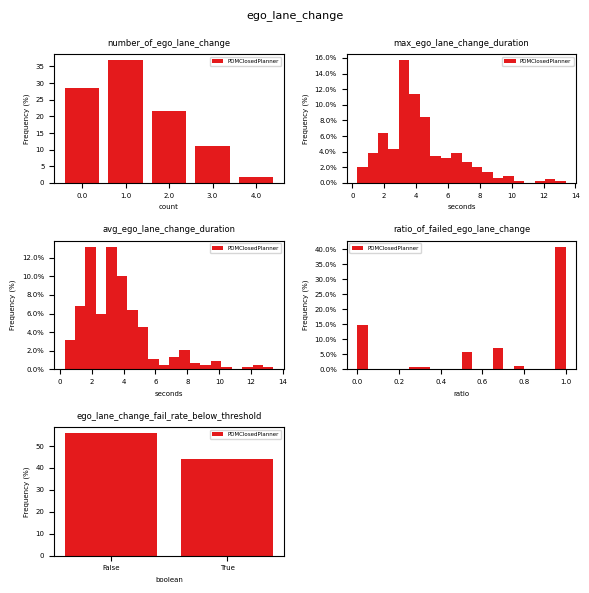

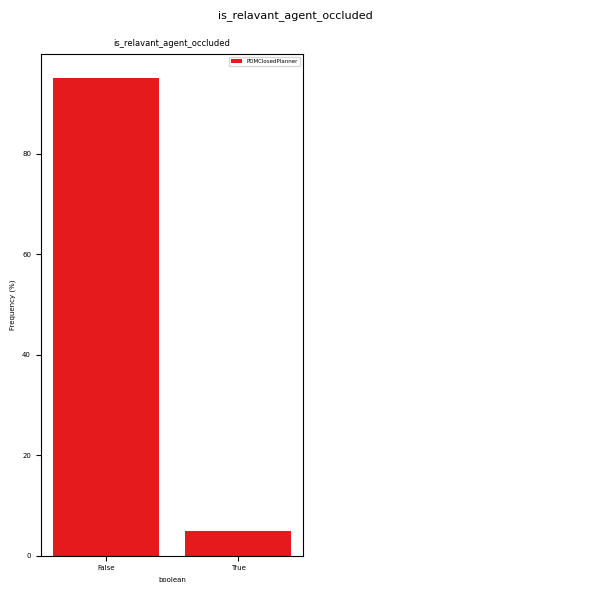

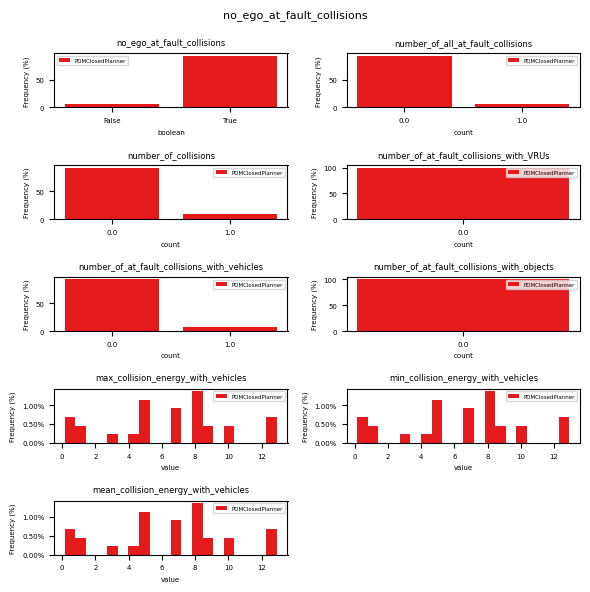

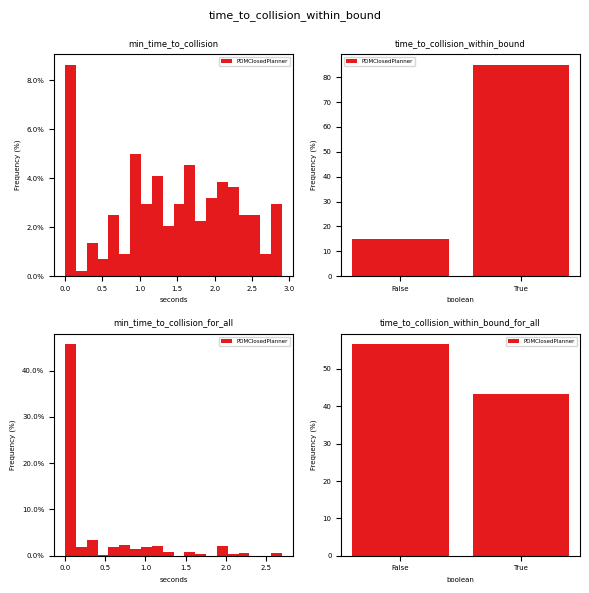

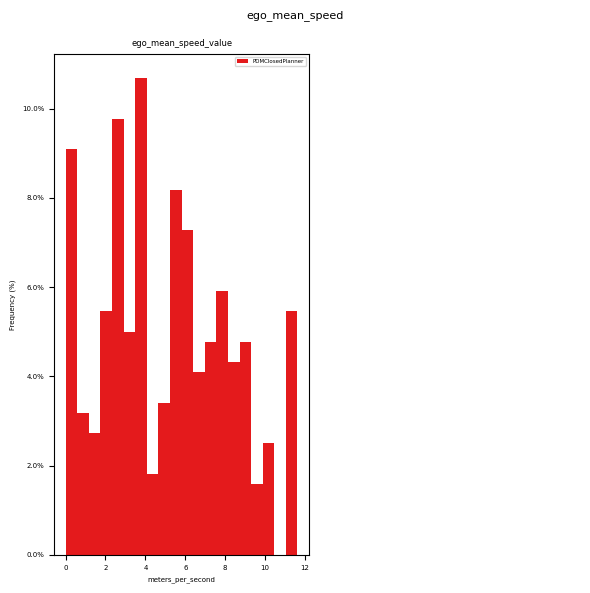

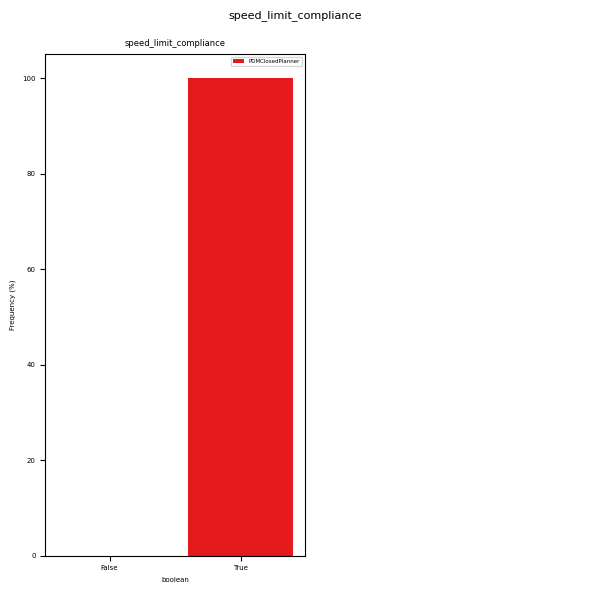

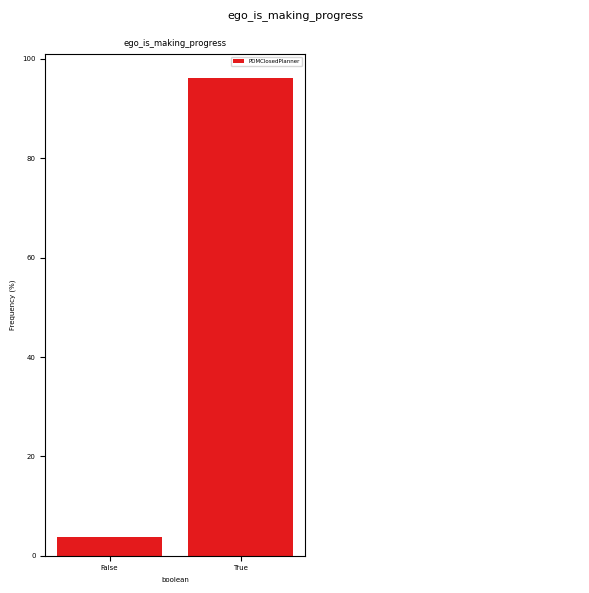

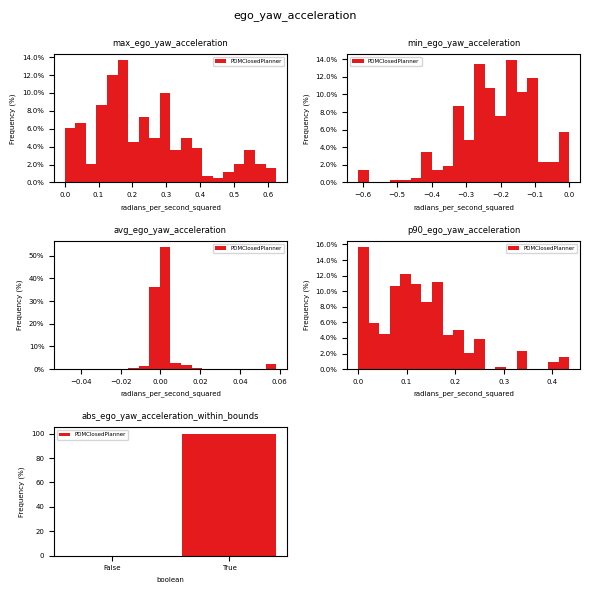

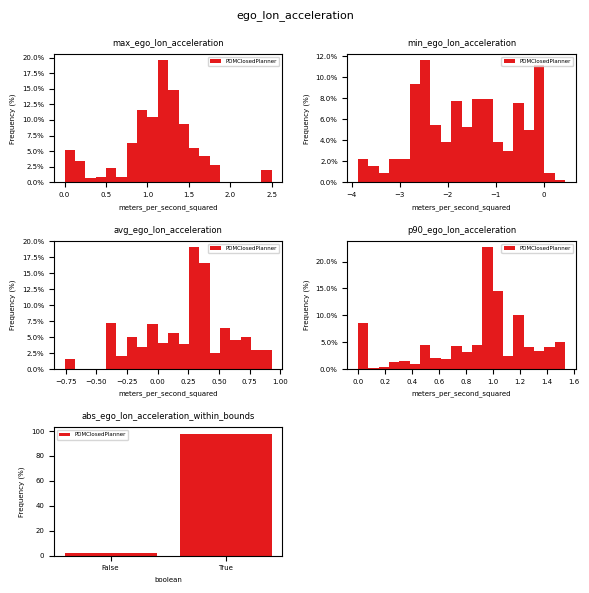

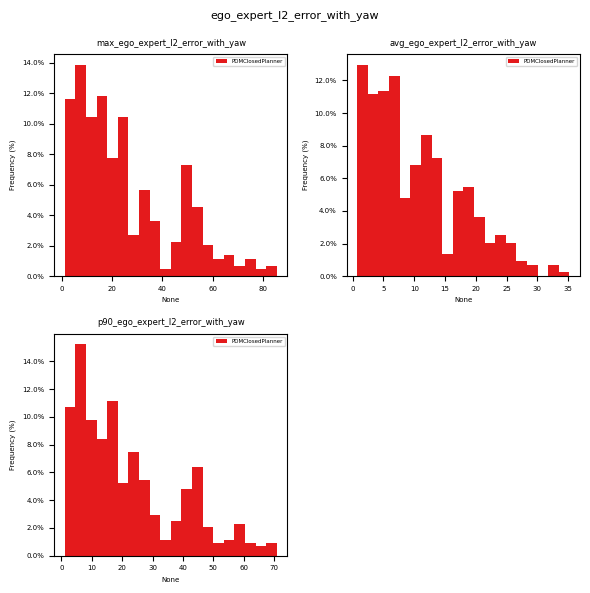

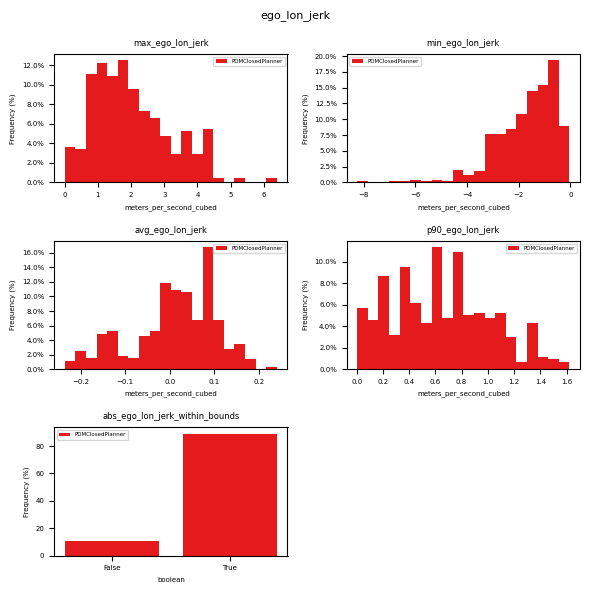

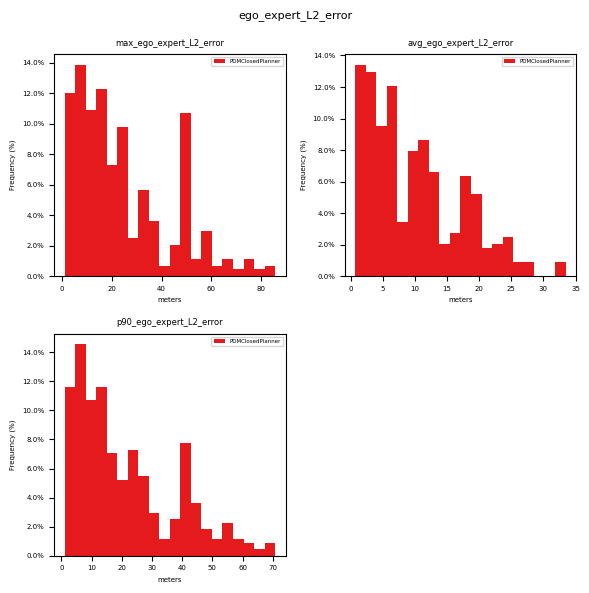

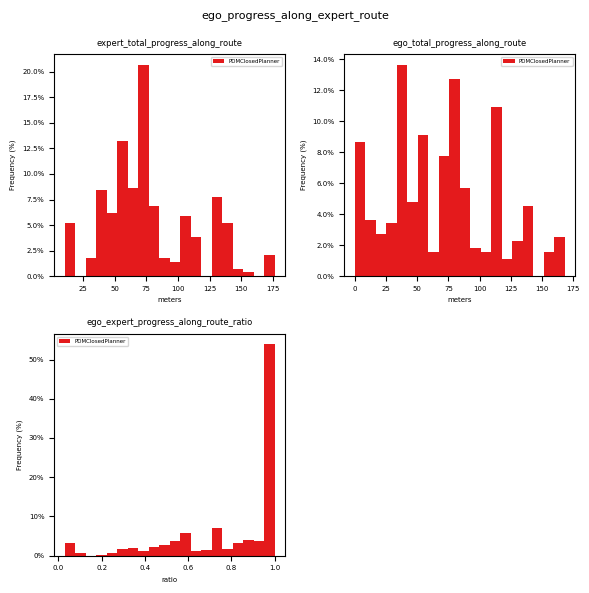

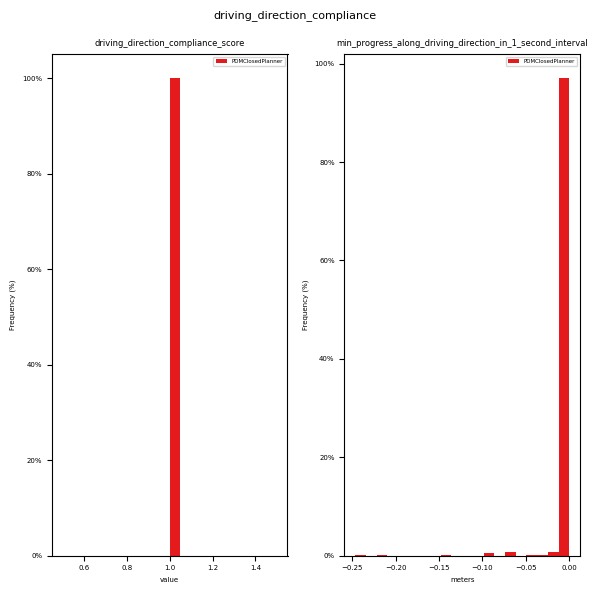

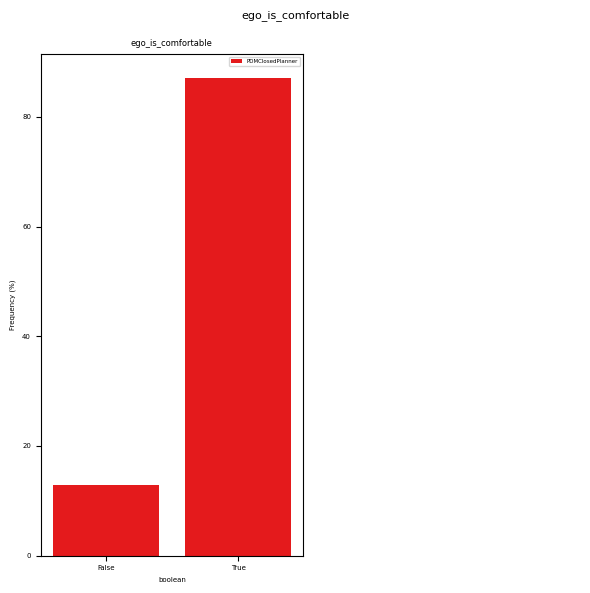

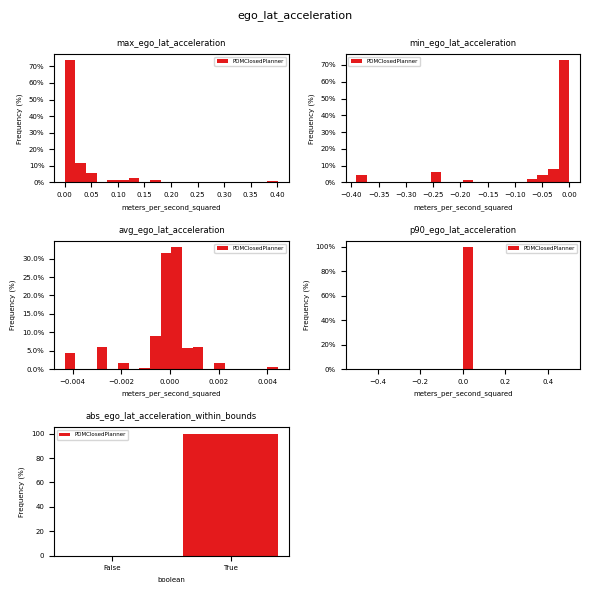

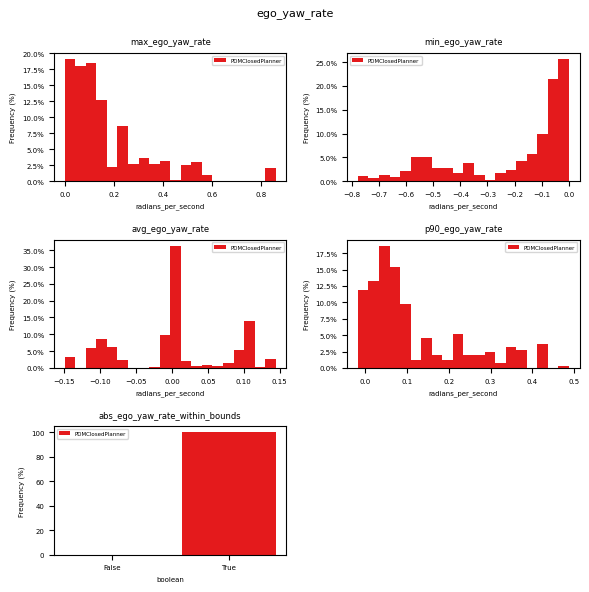

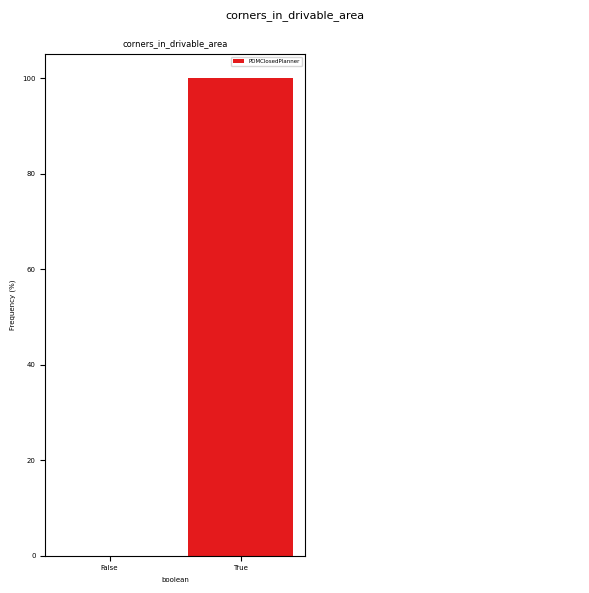

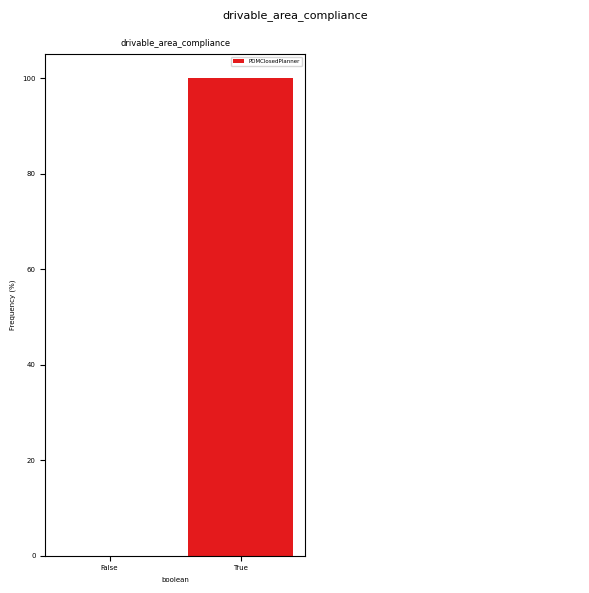

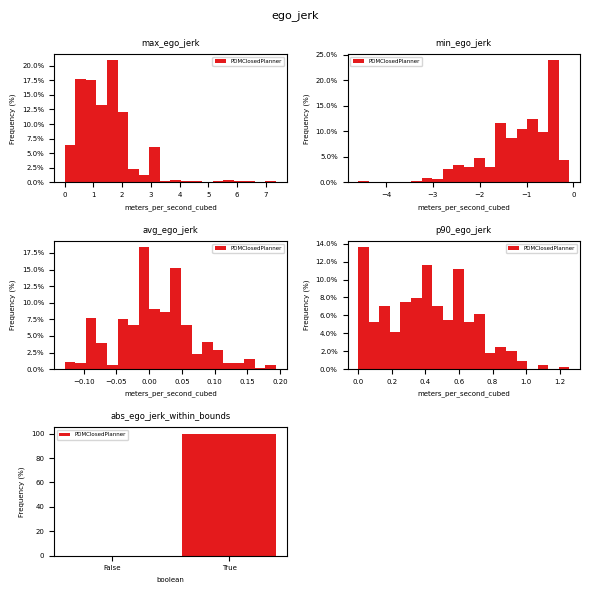

In [ ]:
# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg_occ)

# Now we set up the second running regime

In [ ]:
#########################################

path = output_folder_occ + "/metrics/"
file_path_1 = path + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path_1)
df = df.loc[df["no_ego_collisions_stat_value"] == False]
df = df["scenario_name"]


scenario_list = df.tolist()
print(f"+scenarios_to_check_in_alternate_regime={scenario_list}")

hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)
cfg_unocc = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        # "model=gc_pgp_model",
        # "model.aggregator.pre_train=false",
        # "planner.ml_planner.model_config=${model}",
        # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
        # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
        # "+observation.model=gc_pgp_model",
        # "+observation.model.aggregator.pre_train=false",
        # "+observation.model_config=${model}",
        # f"+observation.checkpoint_path={gc_pgp_ckpt}",
        f"observation.planner_type=pdm_closed",
        # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
        f"observation.occlusion_cfg.occlusion=false",
        "+modify_scenario_simulations=true",
        "+second_testing_round=true",
        f"+scenarios_to_check_in_alternate_regime={scenario_list}",
        "+modifier_types=[conflict-and-occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right, oncoming-left-turn-and-occlusion-injection, conflict-and-occlusion-injection]
        "+occlusion=false",
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
    ],
)

output_folder_unocc = cfg_unocc.output_dir
print('output_folder_unocc = "' + output_folder_unocc + '"')

+scenarios_to_check_in_alternate_regime=['8b80aa05d88b518b_conflict_injection_and_occlusion_injection_3_0.0_48139', 'd8878c93341a583d_conflict_injection_and_occlusion_injection_0_0.0_48667', 'd6cb5239199b531c_conflict_injection_and_occlusion_injection_0_natural_occlusion_5.0_64007', '8b80aa05d88b518b_conflict_injection_and_occlusion_injection_3_5.0_47826', 'baae90210b9f5121_conflict_injection_and_occlusion_injection_0_0.0_53023', 'a7f1731ff7c35faa_conflict_injection_and_occlusion_injection_0_-5.0_63921', '8b80aa05d88b518b_conflict_injection_and_occlusion_injection_6_5.0_47826', '8b80aa05d88b518b_conflict_injection_and_occlusion_injection_3_5.0_48139', 'd6cb5239199b531c_conflict_injection_and_occlusion_injection_0_natural_occlusion_5.0_64008', '8b80aa05d88b518b_conflict_injection_and_occlusion_injection_1_5.0_48139', 'd6cb5239199b531c_conflict_injection_and_occlusion_injection_0_natural_occlusion_0.0_64007', '2b430abcf49554c7_conflict_injection_and_occlusion_injection_1_0.0_64500', '243

(raylet) [2024-03-04 23:18:28,402 E 10326 10341] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_22-23-54_272709_9518 is over 95% full, available space: 649515917312; capacity: 16125711347712. Object creation will fail if spilling is required.


output_folder_unocc = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.03.04.23.18.29"


## Run Second Regime

Global seed set to 0


2024-03-04 23:18:29,504 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2024-03-04 23:18:29,531 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2024-03-04 23:18:29,692 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-03-04 23:18:29,693 WARNING {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:135}  Ray is running, we will shut it down before starting again!
(wrapped_fn pid=10433) Warning: ego in scenario fdd4198cc81c5112 has no conflict lanes intersecting its path [repeated 2x across cluster]


(wrapped_fn pid=10448) WARNING:nuplan.planning.simulation.planner.idm_planner:IDMPlanner could not find valid path to the target roadblock. Using longest route found instead [repeated 3x across cluster]


2024-03-04 23:18:32,304 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-03-04 23:18:33,967	INFO worker.py:1636 -- Started a local Ray instance.


2024-03-04 23:18:34,659 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-03-04 23:18:34,660 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-03-04 23:18:34,660 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-03-04 23:18:34,660 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-03-04 23:18:34,660 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.03.04.23.18.29

2024-03-04 23:18:34,662 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]
(raylet) [2024-03-04 23:18:43,931 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 649515319296; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-03-04 23:18:45,746 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:83}  Building metric engines...
2024-03-04 23:18:45,872 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:85}  Building metric engines...DONE
2024-03-04 23:18:45,872 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:89}  Building simulations from 152 scenarios...
2024-03-04 23:18:47,637 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:151}  Modyfing Scenarios...
[
	'243ea67f27195c7c',
	'2b430abcf49554c7',
	'8b80aa05d88b518b',
	'a7f1731ff7c35faa',
	'baae90210b9f5121',
	'd6cb5239199b531c',
	'd8878c93341a583d'
]
2024-03-04 23:18:47,731 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:203}  Created 29 modified scenarios from 152 scenarios, 59 of which were modifiable.
2024-03-04 23:18:47,731 INFO {/home/ehdykhne/nuplan-devk

Ray objects:   0%|          | 0/29 [00:00<?, ?it/s](wrapped_fn pid=15664) WARNING:nuplan.planning.simulation.planner.idm_planner:IDMPlanner could not find valid path to the target roadblock. Using longest route found instead
(raylet) [2024-03-04 23:18:53,937 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 649515126784; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 23:19:03,945 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 649515061248; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 23:19:13,952 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 649515040768; capacity: 16125711347712. Object creation will fail if spilling is re

2024-03-04 23:22:23,341 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 29
2024-03-04 23:22:23,341 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-03-04 23:22:23,341 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-03-04 23:22:23,347 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.03.04.23.18.29/runner_report.parquet
2024-03-04 23:22:23,347 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:03:53 [HH:MM:SS]
2024-03-04 23:22:23,710 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:00 [HH:MM:SS]
2024-03-04 23:22:23,768 

Rendering histograms:   5%|▍         | 1/21 [00:00<00:03,  5.25it/s]

2024-03-04 23:22:23,938 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-04 23:22:23,940 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(raylet) [2024-03-04 23:22:24,074 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 648884334592; capacity: 16125711347712. Object creation will fail if spilling is required.
Rendering histograms:  14%|█▍        | 3/21 [00:00<00:02,  6.85it/s]

2024-03-04 23:22:24,180 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-04 23:22:24,182 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-04 23:22:24,186 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-04 23:22:24,187 INFO {/home/ehdykhne/miniconda3

Rendering histograms: 100%|██████████| 21/21 [00:02<00:00,  7.33it/s]


2024-03-04 23:22:29,553 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:05 [HH:MM:SS]
2024-03-04 23:22:29,553 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:115}  Finished running simulation!


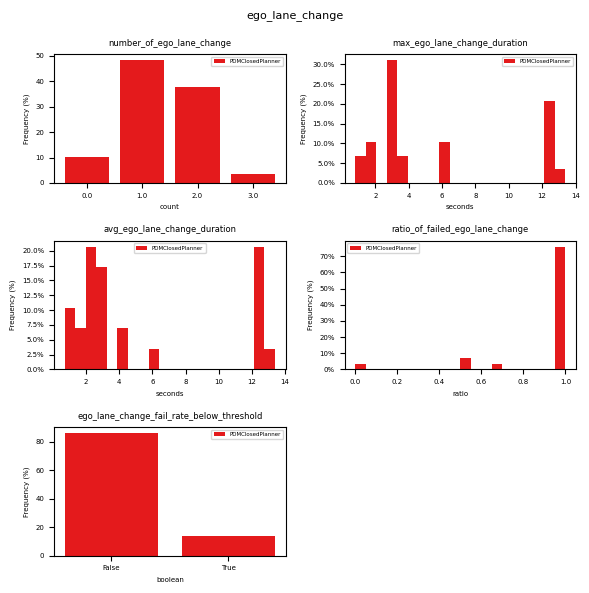

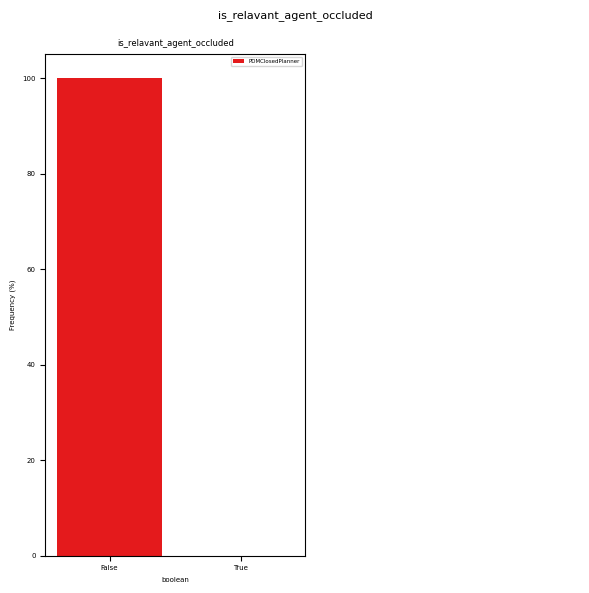

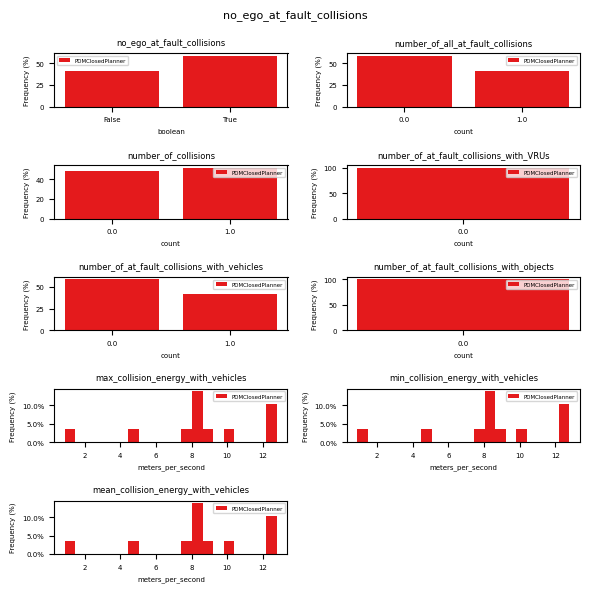

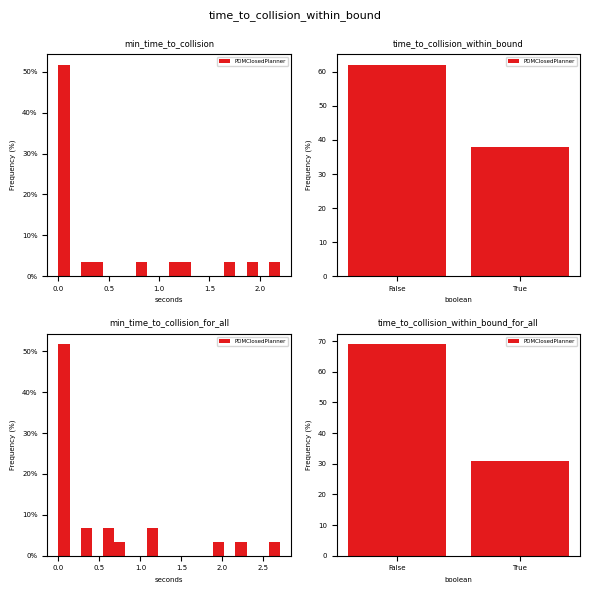

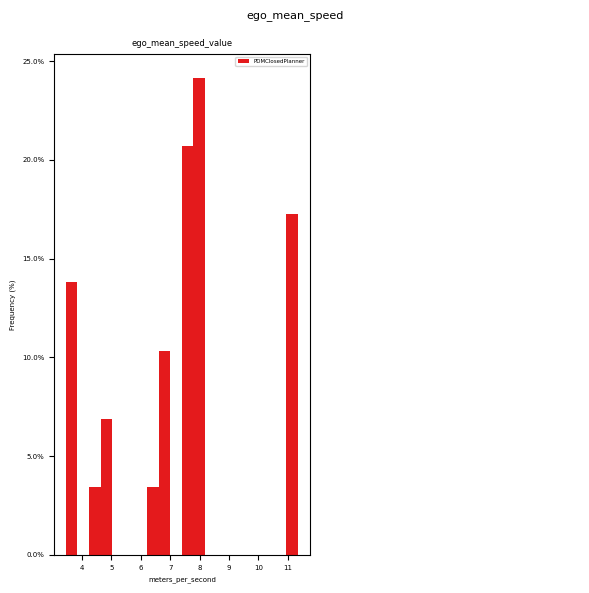

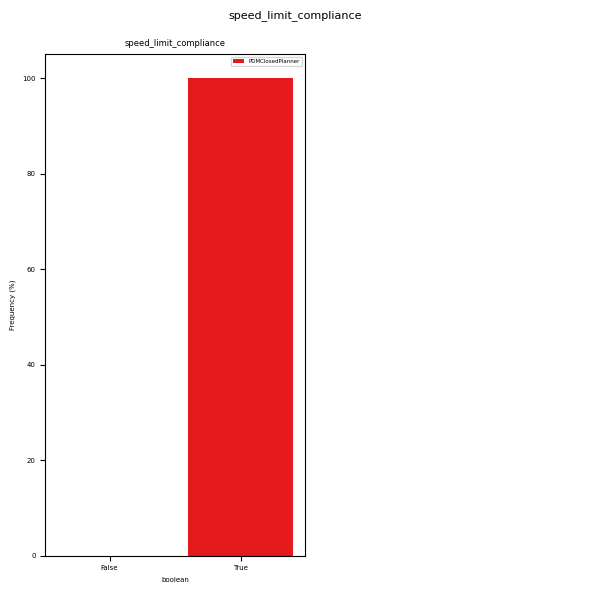

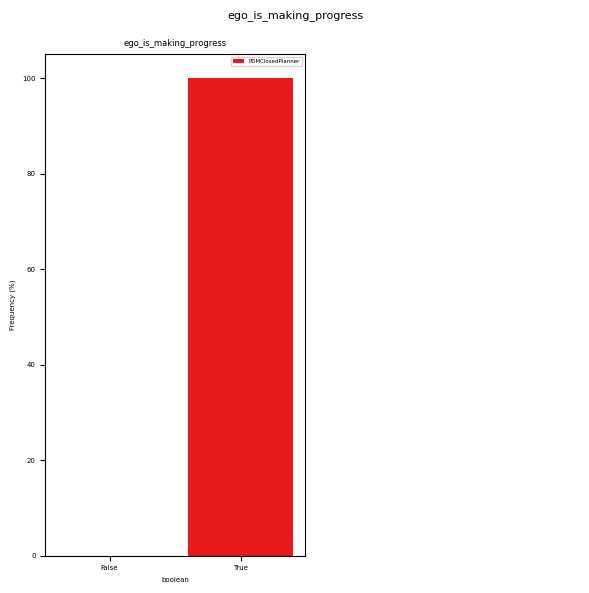

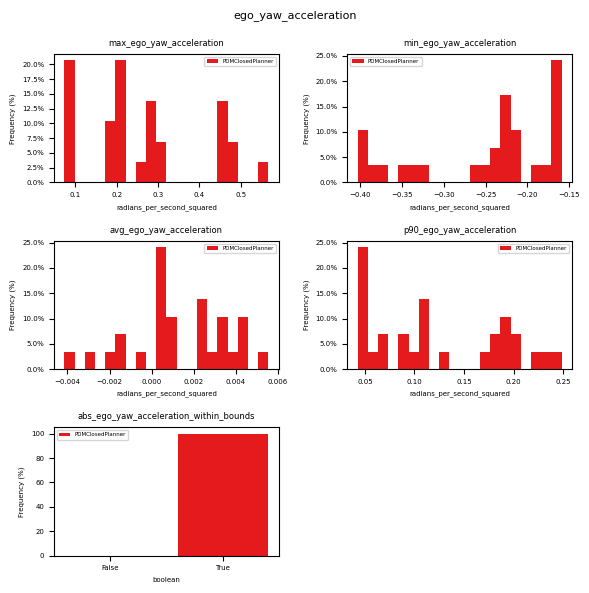

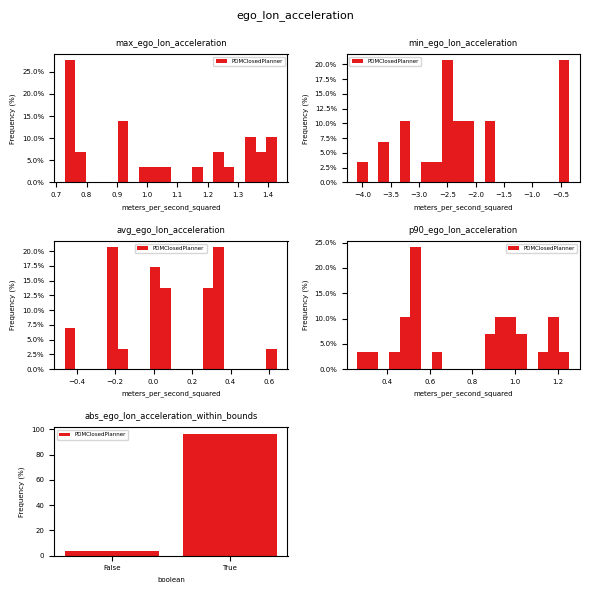

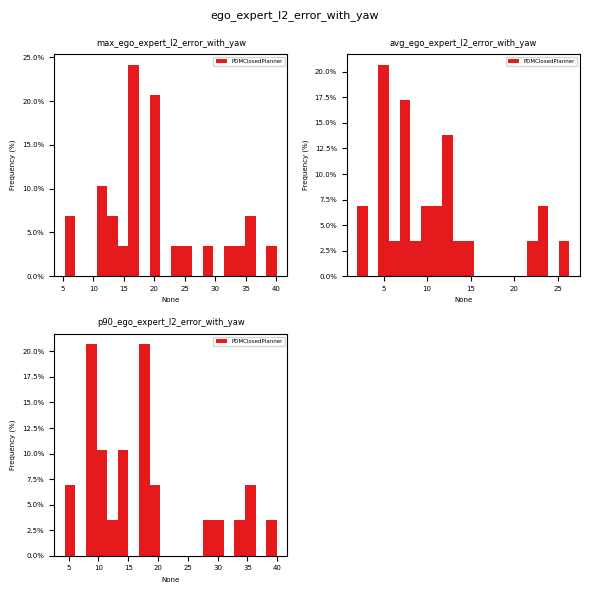

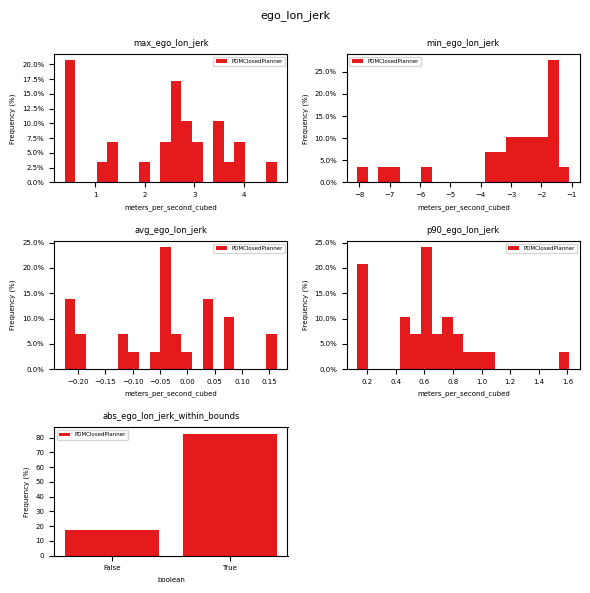

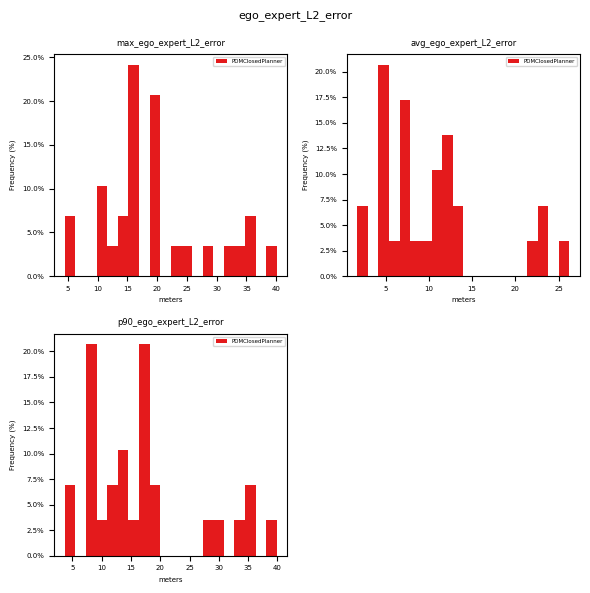

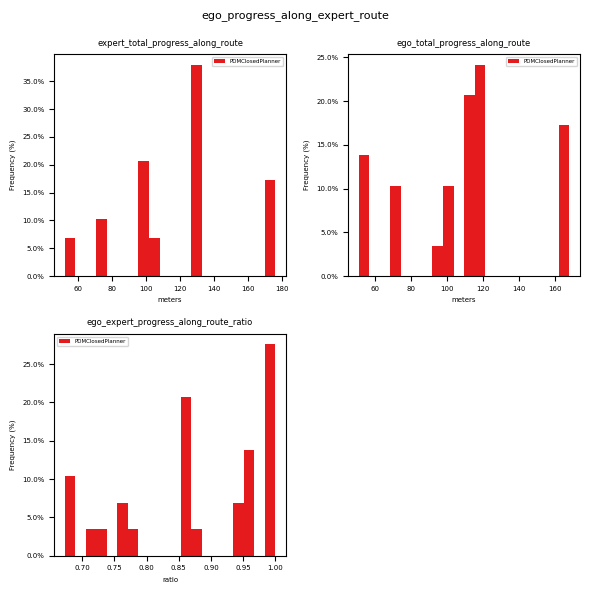

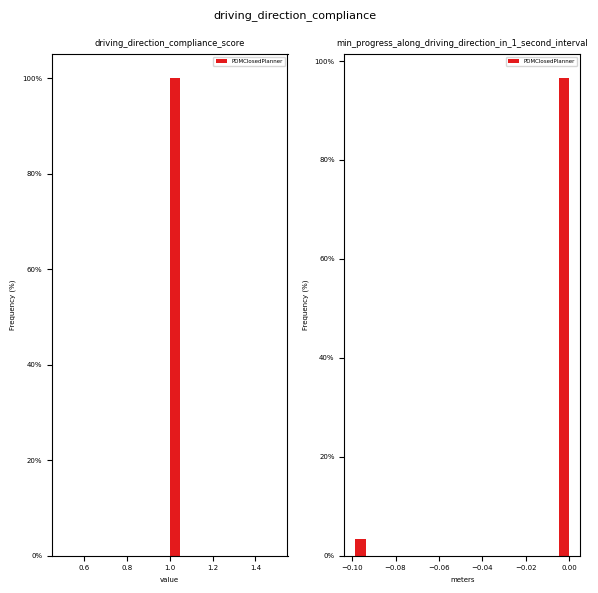

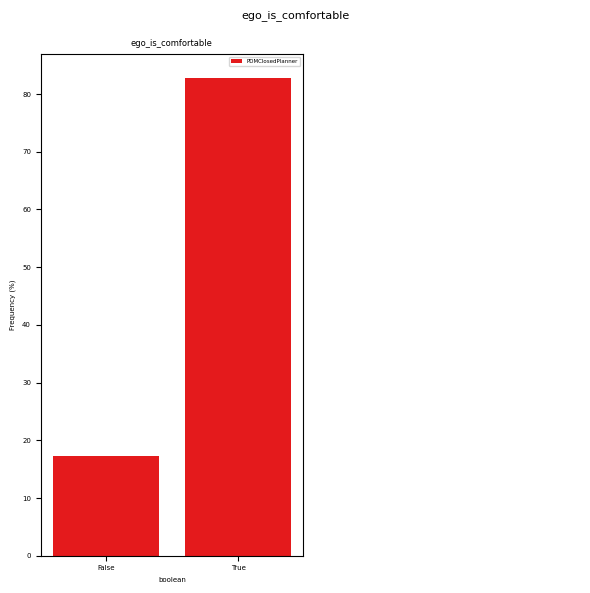

(raylet) [2024-03-04 23:22:34,077 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 648884195328; capacity: 16125711347712. Object creation will fail if spilling is required.


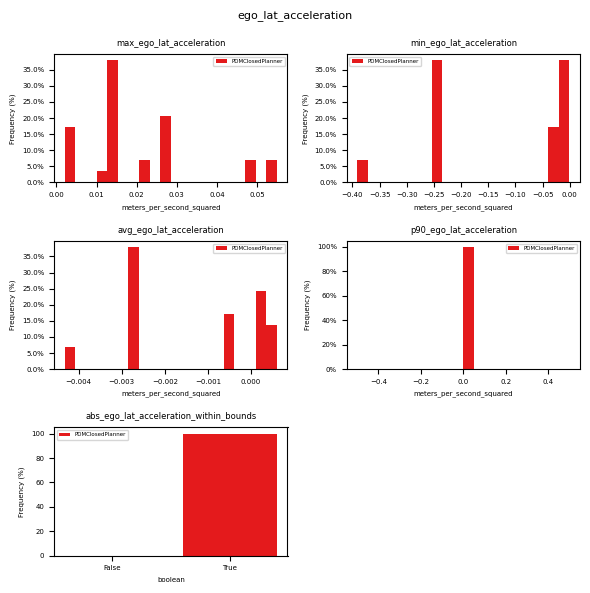

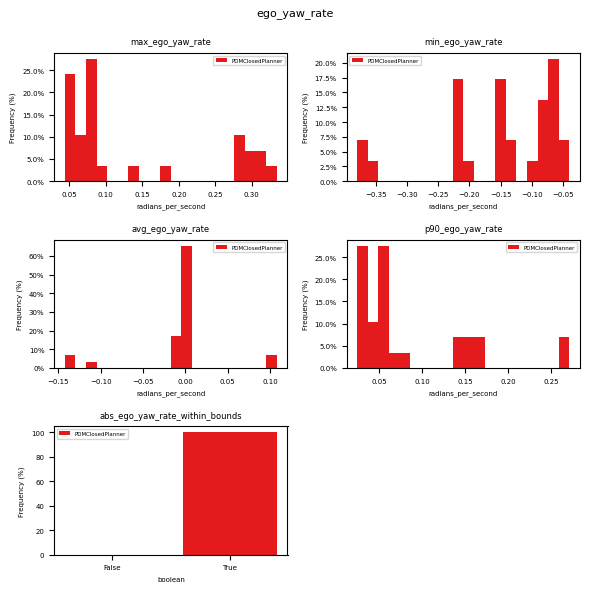

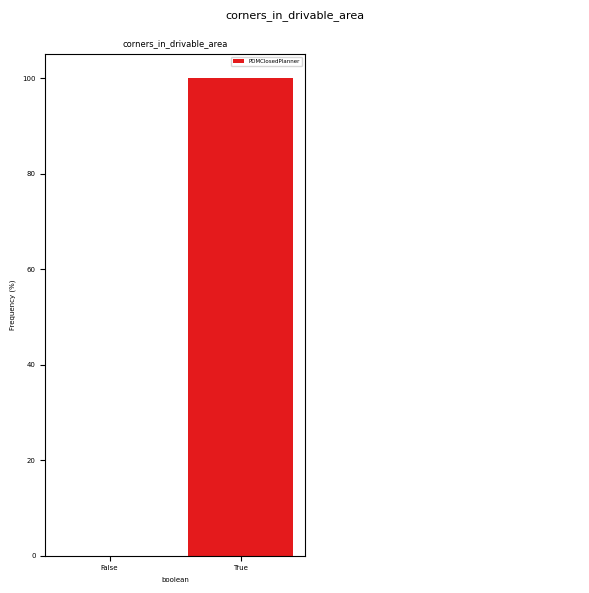

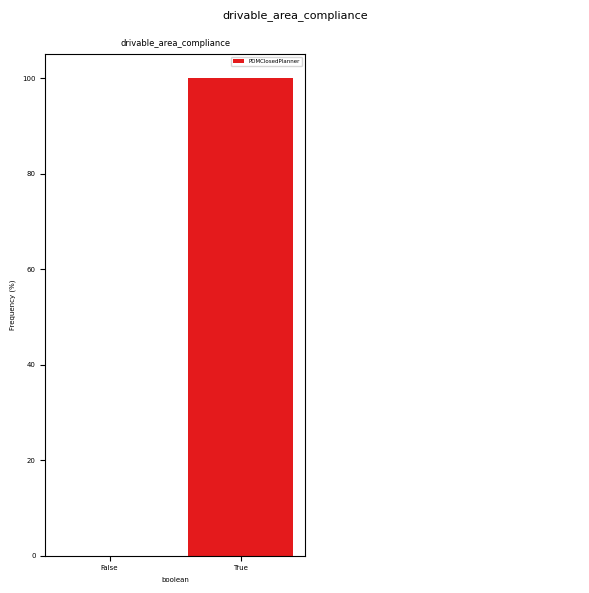

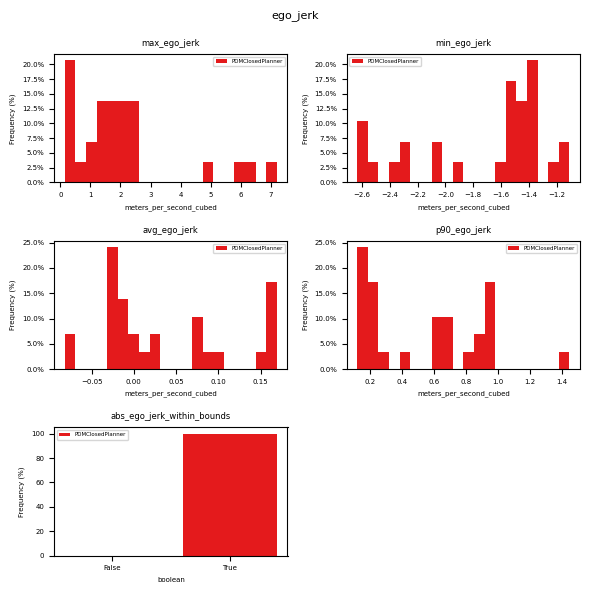

In [ ]:
main_simulation(cfg_unocc)

## Prepare the nuBoard config

In [ ]:
# output_folder_alt = []
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48"
# )

In [ ]:
# scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
# output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.06.45"
# output_folder_unocc = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.55.22"

output_folder = [output_folder_occ, output_folder_unocc]

CONFIG_PATH = "../nuplan/planning/script/config/nuboard"
CONFIG_NAME = "default_nuboard"

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(
    config_name=CONFIG_NAME,
    overrides=[
        f"scenario_builder={scenario_builder}",  # set the database (same as simulation) used to fetch data for visualization
        f"simulation_path={output_folder}",  # [output_folder, output_folder_alt] nuboard file path(s), if left empty the user can open the file inside nuBoard
    ],
)

## Launch nuBoard (open in new tab - recommended)


In [ ]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2024-03-04 23:22:35,204 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2024-03-04 23:22:35,222 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2024-03-04 23:22:35,223 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2024-03-04 23:22:35,223 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2024-03-04 23:22:35,223 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
2024-03-04 23:22:35,223 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possib

(raylet) [2024-03-04 23:22:44,080 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 648884166656; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 23:22:54,082 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 648884158464; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 23:23:04,084 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 648884162560; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 23:23:14,087 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 648884162560; capacity: 16125711347712. Object 

2024-03-04 23:31:26,337 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2024-03-04 23:31:26,453 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0030 seconds.


INFO:tornado.access:200 GET / (10.40.110.168) 505.34ms


2024-03-04 23:31:26,566 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (10.40.110.168) 505.34ms


INFO:tornado.access:101 GET /ws (10.40.110.168) 0.35ms


2024-03-04 23:31:26,913 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (10.40.110.168) 0.35ms
2024-03-04 23:31:26,914 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2024-03-04 23:31:26,914 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created
2024-03-04 23:31:27,623 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2024-03-04 23:31:27,739 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0033 seconds.


INFO:tornado.access:200 GET / (10.40.110.168) 476.28ms


2024-03-04 23:31:27,831 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (10.40.110.168) 476.28ms


(raylet) [2024-03-04 23:31:34,212 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 648883097600; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 23:31:44,214 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 648882962432; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 23:31:54,216 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 648882958336; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 23:32:04,219 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 648882958336; capacity: 16125711347712. Object 

2024-03-04 23:55:18,628 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0519 seconds.


(raylet) [2024-03-04 23:55:24,619 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 648879386624; capacity: 16125711347712. Object creation will fail if spilling is required.
Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 44.00it/s]


2024-03-04 23:55:29,171 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.6660 seconds.


(raylet) [2024-03-04 23:55:34,622 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 648879235072; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 23:55:44,624 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 648879226880; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 23:55:54,627 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 648879226880; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-03-04 23:56:04,629 E 15571 15583] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-03-04_23-18-32_330808_9518 is over 95% full, available space: 648879222784; capacity: 16125711347712. Object 

KeyboardInterrupt: 

: 